# Forecasting the Future: Predicting a Broadcasting Channel's Follower Growth with Bayesian Linear Regression
## by Yongqi Ni, Xin Hu

### Abstract

#### The fluctuation in follower counts serves as a pivotal metric for live broadcasters, indicative not only of the content quality but also constituting a fundamental requisite for revenue generation through avenues such as advertisements and participation in platform projects. The capacity to forecast changes in follower numbers empowers live broadcasters to strategize and optimize their content delivery, thereby sustaining profitability. In this work, we employ Bayesian Linear Regression methodologies to explore the relationship between diverse predictor variables and channel followers' growth. The outcome is not a singular data point prediction but furnishes a probability distribution encapsulating the anticipated growth range. This probabilistic approach offers a depiction of the mean performance across live channels.



### Bayesian Linear Regression with Gaussian Model


#### Bayesian linear regression considers the uncertainty in these coefficients by treating them as random variables with their own probability distributions. It begins with a prior distribution that represents the initial belief or assumption about the distribution of coefficients before observing the data. And the Gaussian model is a good tool to describe the distribution of a continuous variable, representing the likelihood of different outcomes occurring. Specifically bayesian linear regression is posited that the observed responses are drawn from a statistical distribution, typically a normal (Gaussian) distribution. Here, the Gaussian's mean is determined by multiplying the parameters, denoted as beta, with the input variables, X, while the Gaussian's spread is defined by the standard deviation (sigma). Bayesian frameworks extend this probabilistic view to the parameters themselves, considering them as random variables with their own distributions. The goal is to calculate the posterior probability distribution of these parameters, taking into account the given inputs, X, and observed outputs, y. This posterior is computed by multiplying the likelihood of the observed data by the prior probability of the parameters and then normalizing the result. If prior knowledge is available, it can inform the selection of priors for the parameters; otherwise, non-informative priors are chosen, which are broad distributions signifying no specific initial hypothesis about the parameters' values, allowing the observed data to predominantly shape the outcomes. Typically, the normal distribution is chosen for beta, while a half-cauchy distribution, known for its heavy tails, is selected for sigma.

# Library Import

In [113]:
# Data loading and processing library
import pandas as pd
import numpy as np
# Set random seed to 42 as a standard
np.random.seed(42)

# Figure plotting library
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)
import seaborn as sns
from IPython.core.pylabtools import figsize

# Helpers
from scipy.stats import percentileofscore
from scipy import stats

# Comparison with other ML models Library
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Splitting the original dataset into training and testing dataset
from sklearn.model_selection import train_test_split

# Get metrics methods
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# For fit
import pymc as pm
import bambi as bmb
import arviz as az
import xarray as xr


# Methods

## Data Loading

#### The datasets were acquired from Stream Charts, encompassing XQC’s streaming data spanning the years 2019 through 2023. These datasets offer a comprehensive view of XQC’s streaming activities, capturing a wealth of information that includes viewership, streaming duration, and more.

In [114]:
# df = pd.read_csv('data/xQc_channel_stats_by_day(2019).csv')
# Load multiple dataset into one dataset
df = pd.concat( 
    map(pd.read_csv, ['data/xQc_channel_stats_by_day(2019).csv', 'data/xQc_channel_stats_by_day(2020).csv','data/xQc_channel_stats_by_day(2021).csv','data/xQc_channel_stats_by_day(2022).csv','data/xQc_channel_stats_by_day(2023).csv']), ignore_index=True) 
print(df) 

df.head()

                  Date Hours_Watched HW gain % Avg_Viewers Avg. View. Gain %  \
0        01 June, 2019       136 667   -28.40%      14 261             7.08%   
1        02 June, 2019       186 766    36.66%      16 479            15.55%   
2        03 June, 2019       172 911    -7.42%      15 036            -8.76%   
3        04 June, 2019       182 648     5.63%      16 480             9.60%   
4        05 June, 2019       179 554    -1.69%      14 559           -11.66%   
...                ...           ...       ...         ...               ...   
1599  17 October, 2023        80 113   -54.25%      32 046            -5.44%   
1600  18 October, 2023        38 831   -51.53%      35 843            11.85%   
1601  19 October, 2023             -         -           -                 -   
1602  20 October, 2023             -         -           -                 -   
1603  21 October, 2023             -         -           -                 -   

     Peak_Viewers  Airtime Followers_Ga

,Date,Hours_Watched,HW gain %,Avg_Viewers,Avg. View. Gain %,Peak_Viewers,Airtime,Followers_Gained,Live Views,Authorized Viewers,Auth. / All Viewers Ratio,Unique Viewers
0,"01 June, 2019",136 667,-28.40%,14 261,7.08%,17 545,9h 35m,4 750,0,0,0%,0
1,"02 June, 2019",186 766,36.66%,16 479,15.55%,30 275,11h 20m,2 135,0,0,0%,0
2,"03 June, 2019",172 911,-7.42%,15 036,-8.76%,19 614,11h 30m,1 745,0,0,0%,0
3,"04 June, 2019",182 648,5.63%,16 480,9.60%,24 932,11h 5m,2 173,0,0,0%,0
4,"05 June, 2019",179 554,-1.69%,14 559,-11.66%,21 410,12h 20m,2 171,0,0,0%,0


In [115]:
# Check shape of the combined dataset
df.shape

(1604, 12)

In [116]:
df.describe()

,Date,Hours_Watched,HW gain %,Avg_Viewers,Avg. View. Gain %,Peak_Viewers,Airtime,Followers_Gained,Live Views,Authorized Viewers,Auth. / All Viewers Ratio,Unique Viewers
count,1604,1604,1604,1604,1604,1604,1604,1604,1604,1604,1604,1604
unique,1604,1471,1395,1458,1319,1458,259,1425,685,333,59,450
top,"01 June, 2019",-,-,-,-,-,-,507,0,0,0%,0
freq,1,134,134,134,134,134,134,6,787,1022,320,1022


## Data Processing

#### After ensuring data quality, we performed feature engineering. We excluded Date, as our focus was on variable effects irrespective of date. Percentage gain variables were also removed, as they represented only the fluctuation of values. Variables with consistently zero values, indicating no impact, were dropped. Thus, the primary feature variables in our analysis were hours watched, average viewers, peak viewers, and airtime with followers gained as the objective variable. Moreover, we converted the airtime column from hours and minutes to decimal hours (e.g., 3h 45m becomes 3.75 hours). We also used a lambda function to remove space gaps in the followers gained column, converting the strings to floats. Additionally, we replaced dashes representing zero values in columns like average viewers and peak viewers with actual zeros and corrected non-float or integer columns by removing thousands separators. 

In [117]:
# Convert the time format like from 8h 30m to 8.5
def convert_to_decimal_hours(time_str):
    if time_str == '-':
        return 0.0

    hour = 0
    minute = 0

    if 'h' in time_str:
        parts = time_str.split('h')
        hour = int(parts[0])
        time_str = parts[1]

    if 'm' in time_str:
        minute = int(time_str.split('m')[0])

    return hour + minute / 60.0

# Apply the conversion function
df['Airtime'] = df['Airtime'].apply(convert_to_decimal_hours)


In [118]:
if  df['Followers_Gained'].dtype != "float64":
    df["Followers_Gained"] = df["Followers_Gained"].apply(lambda x: x.replace(' ', '')).astype(float)



In [119]:
# Convert data to decimal places
def convert_to_decimal(time_str):
    if time_str == '-':
        return 0
    return int(time_str.replace(" ", ""))
if  df['Avg_Viewers'].dtype != "int64" and df['Hours_Watched'].dtype != "int64":
    df['Avg_Viewers'] = df['Avg_Viewers'].apply(convert_to_decimal)
    df['Hours_Watched'] = df['Hours_Watched'].apply(convert_to_decimal)
    df['Peak_Viewers'] = df['Peak_Viewers'].apply(convert_to_decimal)


In [120]:
df['Followers_Gained'].describe()

count    1.604000e+03
mean     6.583539e+03
std      7.554078e+04
min     -1.337349e+06
25%      1.364750e+03
50%      2.858000e+03
75%      5.334000e+03
max      1.368963e+06
Name: Followers_Gained, dtype: float64

## Quality Control

#### Besides the XQC streaming data from 2019 to 2023 are gained based on the standards of free of errors, missing values, duplicates, and inconsistencies, the interquartile range (IQR) was also applied for outlier detection. The IQR, calculated as Q3-Q1, measures statistical dispersion. To calculate it, we first ordered our data set, ignoring date filters since we focus on average variable impact over time. We split the data at the median, defining Q1 and Q3 as the medians of the lower and upper halves, respectively. Subtracting Q1 from Q3 gives the IQR. Data points more than 1.5 times the IQR above Q3 or below Q1 were considered outliers and removed, creating a filtered dataset. This process prevented outliers from distorting data distributions and affecting predictions.

In [121]:
# Remove outliers from dataset
cols = ['Followers_Gained'] # one or more

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df_filtered = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]



In [122]:
df_filtered['Followers_Gained'].value_counts(bins=13)
print(df_filtered['Followers_Gained'].value_counts(bins=13).index)

IntervalIndex([(1782.077, 2964.692], (599.462, 1782.077], (-583.154, 599.462], (2964.692, 4147.308], (4147.308, 5329.923] ... (7695.154, 8877.769], (10060.385, 11243.0], (-1765.769, -583.154], (-4146.375, -2948.385], (-2948.385, -1765.769]], dtype='interval[float64, right]')


## Data Analysis 

#### The XQC streaming statistics dataset from 2019 to 2023 had many outliers, which we filtered using the Interquartile Range. Post-filtering, the followers gained distribution is closer to normal but not perfectly (Figure 1). Most days, the channel gains up to 2,000 followers, with the distribution's peak at the lower end, for up to about 13,000 followers, indicating modest daily increases rather than large spikes. Negative values suggest occasional follower decreases, possibly due to off days or reduced airtime.


c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


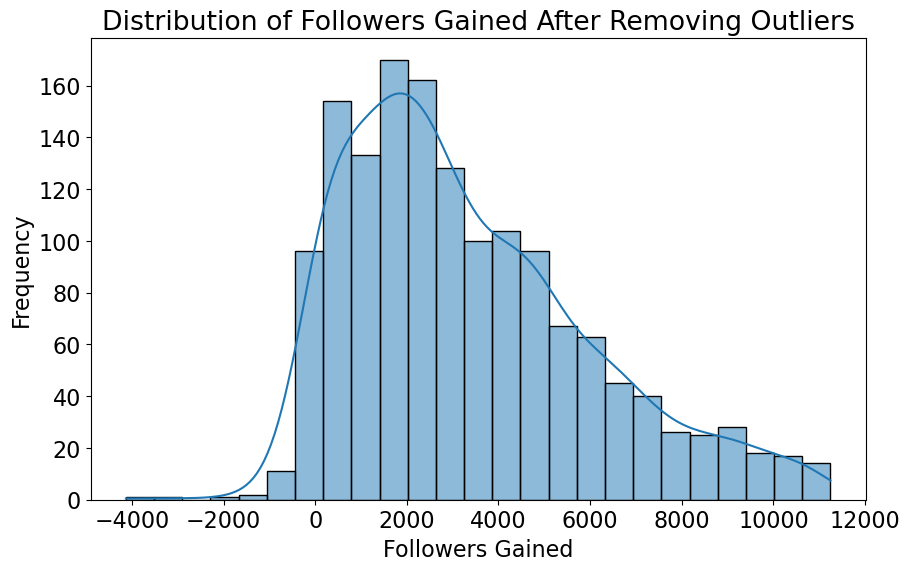

In [123]:
# Plot histogram and kdf for followers gained
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['Followers_Gained'], kde=True)
plt.title('Distribution of Followers Gained After Removing Outliers')
plt.xlabel('Followers Gained')
plt.ylabel('Frequency')
plt.show()

In [124]:
# Calculate percentile for followers gained
df_filtered['percentile'] = df_filtered['Followers_Gained'].apply(lambda x: percentileofscore(df_filtered['Followers_Gained'], x))

C:\Users\thech\AppData\Local\Temp\ipykernel_19116\417195752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['percentile'] = df_filtered['Followers_Gained'].apply(lambda x: percentileofscore(df_filtered['Followers_Gained'], x))


Text(0.5, 1.0, 'Followers Gained Percentiles')

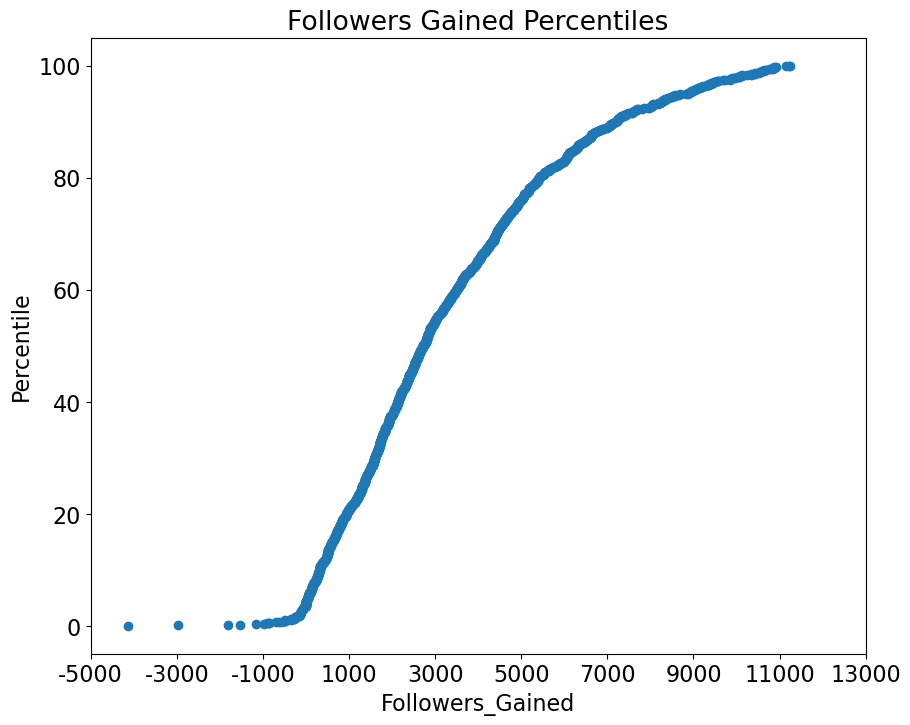

In [125]:
# Plot percentiles figure for followers gained
plt.figure(figsize = (10, 8))
plt.plot(df_filtered['Followers_Gained'], df_filtered['percentile'], 'o')
plt.xticks(range(-5000, 14000, 2000), range(-5000, 14000, 2000))
plt.xlabel('Followers_Gained'); plt.ylabel('Percentile'); plt.title('Followers Gained Percentiles')

In [126]:
print('50th percentile score:', np.min(df_filtered.loc[df_filtered['percentile'] > 50, 'Followers_Gained']))
print('Minimum Followers gained needed for 90th percentile:', np.min(df_filtered.loc[df_filtered['percentile'] > 90, 'Followers_Gained']))

50th percentile score: 2725.0
Minimum Followers gained needed for 90th percentile: 7210.0


In [127]:
# Find the variables that are most correlated with Follower_Gained and split them into 75%/25% train and test set randomly
def processing_data(df):
    # Targets are Followers_Gained
    targets = df['Followers_Gained']
    
    # Drop 'Date', 'Unique Viewers', 'Authorized Viewers', 'Live Views', 'Auth. / All Viewers Ratio','percentile', 'HW gain %', 'Avg. View. Gain %'
    df = df.drop(columns=['Date', 'Unique Viewers', 'Authorized Viewers', 'Live Views', 'Auth. / All Viewers Ratio','percentile', 'HW gain %', 'Avg. View. Gain %'])
    correlated = df.corr().abs()['Followers_Gained'].sort_values(ascending=False)
    correlated = correlated[:5]
    df = df.iloc[:, df.columns.get_indexer(correlated.index)]
    
    # Split dataset into 75%/25% train and test set
    X_train, X_test, y_train, y_test = train_test_split(df, targets, test_size = 0.25, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [128]:
# Execute processing_data and visualize part of them
X_train, X_test, y_train, y_test = processing_data(df_filtered)

X_train.head()

,Followers_Gained,Hours_Watched,Airtime,Peak_Viewers,Avg_Viewers
1328,625.0,287098,4.083333,86962,70310
1592,160.0,109247,3.083333,51225,35432
1290,852.0,273774,4.833333,73165,56643
180,2794.0,290106,11.666667,39071,24866
1126,6370.0,746702,12.416667,81389,60137


In [129]:
print(X_train.shape)
print(X_test.shape)


(1126, 5)
(376, 5)


c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

c:\Users\thech\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1544: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(x=data_k, label=label_k, color=color, **plot_kwargs)
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1544: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(x=data_k, label=label_k, colo

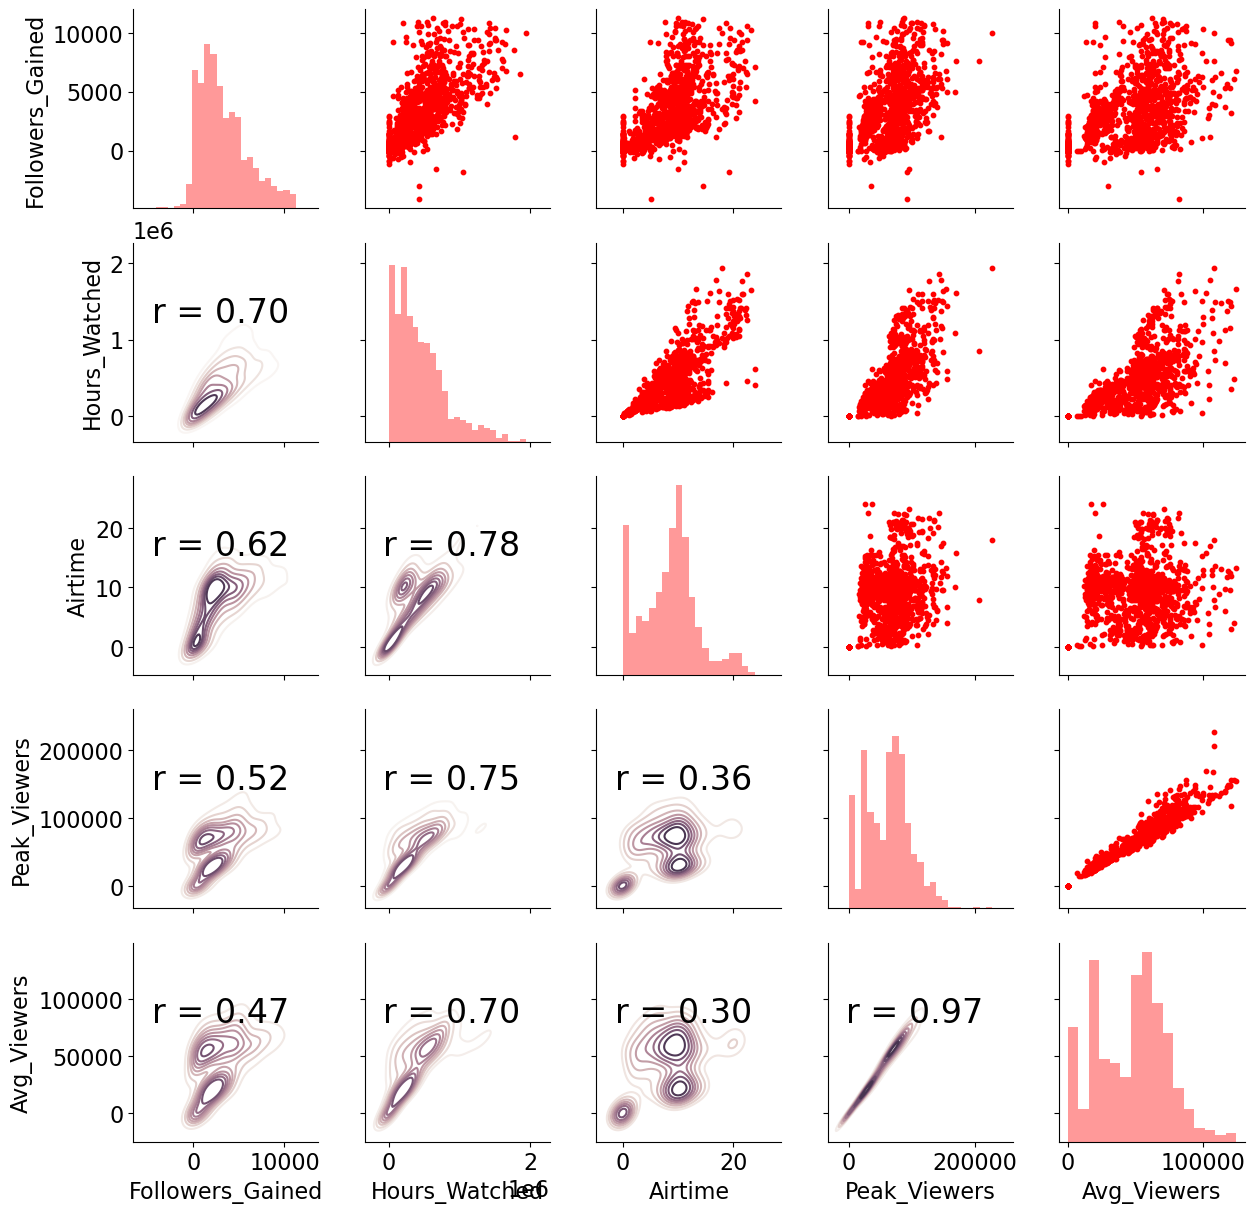

In [130]:
# Do correlation coefficient compuatation
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1, hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Each grid is paired
g = sns.PairGrid(X_train)

# Set up scatter plots on the right upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Set up distribution figures on the diagonal line
g.map_diag(sns.distplot, kde=False, color = 'red')

# Set up density plots and correlation coefficients on the left lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc)

In [131]:
# Build relation to the median Followers_Gained column
X_plot = X_train.copy()
# If followers_gained >= 50% percentile value then we plot
X_plot['relation_median'] = (X_plot['Followers_Gained'] >= 2725.0)
X_plot['relation_median'] = X_plot['relation_median'].replace({True: 'above', False: 'below'})
X_plot = X_plot.drop(columns='Followers_Gained')

c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

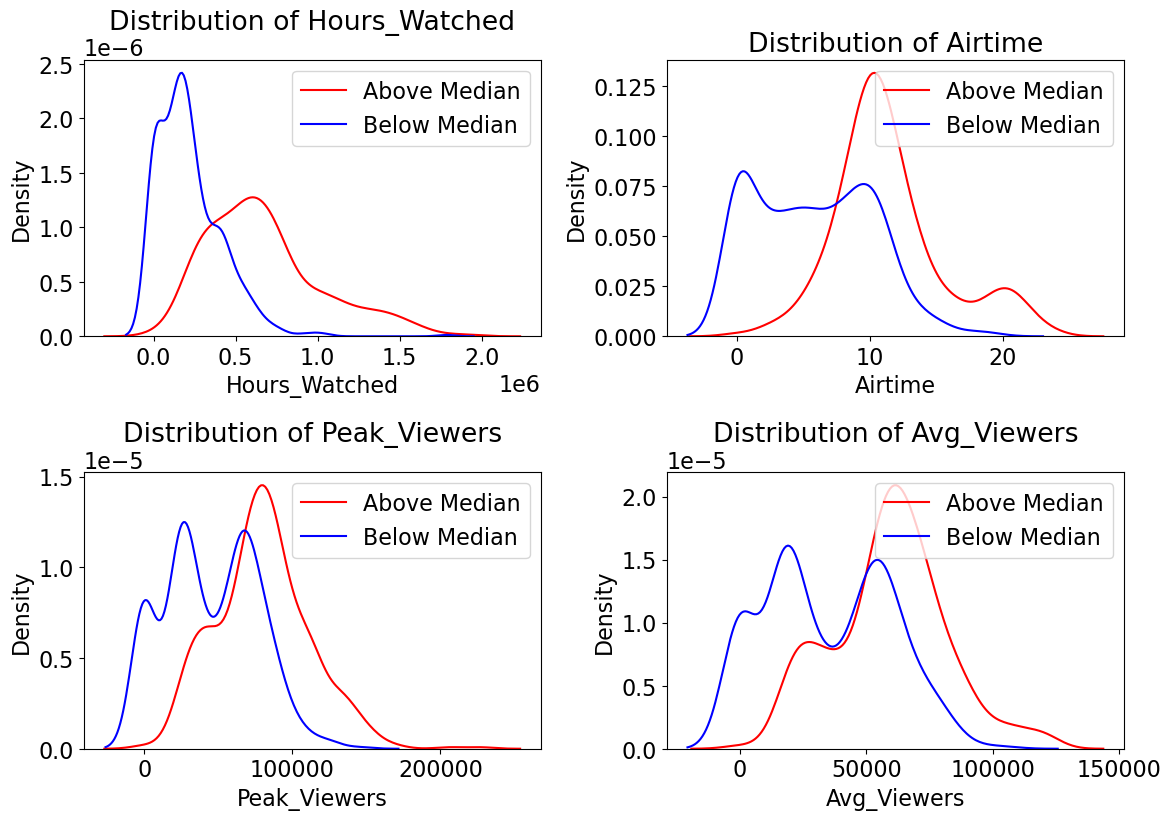

In [132]:
# Set the size of the plot
plt.figure(figsize=(12, 12))
# Plot the distribution of each variable and color them red if they are above median and blue if below it
for i, col in enumerate(X_plot.columns[:-1]):
    plt.subplot(3, 2, i + 1)
    red = X_plot[X_plot['relation_median'] == 'above']
    blue = X_plot[X_plot['relation_median'] == 'below']
    sns.kdeplot(red[col], label = 'Above Median', color = 'red')
    sns.kdeplot(blue[col], label = 'Below Median', color = 'blue')
    plt.legend(); plt.title('Distribution of %s' % col)
    
plt.tight_layout()

In [133]:
# Compute MAE and RMSE to evaluate our predictions
def MAE_AND_RMSE(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse

In [134]:
# We set naive baseline to the median
median_pred = X_train['Followers_Gained'].median()
median_preds = [median_pred for _ in range(len(X_test))]
true = X_test['Followers_Gained']

In [135]:
# Print the naive baseline metrics
mb_mae, mb_rmse = MAE_AND_RMSE(median_preds, true)
print('Median Baseline  MAE: {:.6f}'.format(mb_mae))
print('Median Baseline RMSE: {:.6f}'.format(mb_rmse))

Median Baseline  MAE: 2089.569149
Median Baseline RMSE: 2672.055318


In [136]:
# Evaluate different ML methods on training and test dataset
def evaluate(X_train, X_test, y_train, y_test):
    # Dataset processing and Model loading
    comparison = ['Linear Regression','Random Forest', 'SVM','Baseline']
    X_train = X_train.drop(columns='Followers_Gained')
    X_test = X_test.drop(columns='Followers_Gained')
    
    # Function utilization setup
    LR = LinearRegression()
    RF = RandomForestRegressor(n_estimators=50)
    SVM = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')    
    # Dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = comparison)
    
    # Do the training and predictions for each model
    for i, model in enumerate([LR, RF, SVM]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # apply MAE and RMSE for them
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # Put results into the dataframe
        model_name = comparison[i]
        results.loc[model_name, :] = [mae, rmse]
    
    # Median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [137]:
results = evaluate(X_train, X_test, y_train, y_test)

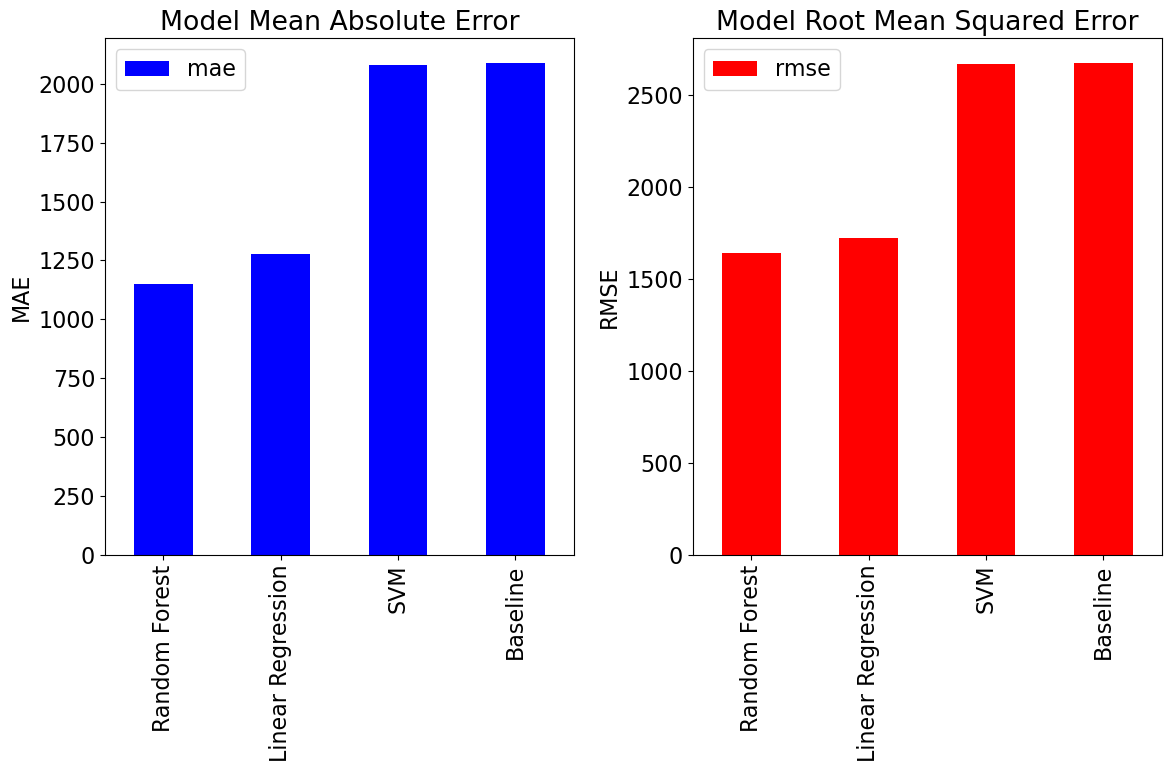

In [138]:
figsize(12, 8)
matplotlib.rcParams['font.size'] = 16

# Plot RMSE
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
plt.title('Model Mean Absolute Error'); plt.ylabel('MAE')

# Plot MAE
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
plt.title('Model Root Mean Squared Error'); plt.ylabel('RMSE')

plt.tight_layout()

In [139]:
results

,mae,rmse
Linear Regression,1276.071265,1718.036577
Random Forest,1150.554074,1638.559502
SVM,2082.496099,2666.070514
Baseline,2089.569149,2672.055318


In [140]:
print('The Linear regression regressor is {:0.2f}% better than the naive baseline.'.format(
    (100 * abs(results.loc['Linear Regression', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))

The Linear regression regressor is 38.93% better than the naive baseline.


## Algorithm

#### To have data for model validation and sampling, we split our dataset into a 75\% training set and a 25\% testing set using Scikit-learn, with a fixed random state for consistent splits, which helped prevent overfitting and better evaluated model performance on unseen data. We used Bayesian linear regression with the formula followers gained ~ hours watched + airtime + peak viewers + average viewers, applying it to the No-U-Turn Sampler (NUTS) algorithm via the Bambi.Model function on the training set data. Two parallel Markov Chain Monte Carlo (MCMC) chains with 2,000 draws each were used, aiming to approximate the posterior distribution of model parameters as the number of samples increases. 	

In [141]:
linearR = LinearRegression()
linearR.fit(X_train.drop(columns='Followers_Gained'), y_train)

ols_formula = 'Followers_Gained = %0.5f +' % linearR.intercept_
for i, col in enumerate(X_train.columns[1:]):
    ols_formula += ' %0.5f * %s +' % (linearR.coef_[i], col)
    
' '.join(ols_formula.split(' ')[:-1])

'Followers_Gained = 305.55639 + 0.00293 * Hours_Watched + 135.77561 * Airtime + 0.02160 * Peak_Viewers + -0.01698 * Avg_Viewers'

In [142]:
# Use R formula syntax to formulate Bayesian Linear Regression
formula = 'Followers_Gained ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'Followers_Gained ~ Hours_Watched + Airtime + Peak_Viewers + Avg_Viewers'

In [143]:
# Build the model with our formula above and training data
model = bmb.Model(formula, data = X_train)
    
# Perform Markov Chain Monte Carlo sampling 
# Sampler will sample two chains in parallel, drawing 2,000 draws for each one.
normal_trace = model.fit(draws=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Followers_Gained_sigma, Intercept, Hours_Watched, Airtime, Peak_Viewers, Avg_Viewers]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 64 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [144]:
print(list(normal_trace.posterior)[:-1])

['Intercept', 'Hours_Watched', 'Airtime', 'Peak_Viewers', 'Avg_Viewers']


In [145]:
def plot_traces(trace):
    # Traceplot with vertical lines at the mean value
    # We have 2 MCMC Chains so there are two colors of chains for each MCMC chain
    ax = az.plot_trace(trace, figsize=(14, len(list(normal_trace.posterior.keys()))*4), lines=[(var_name, {},var_metrics['mean']) for var_name, var_metrics in az.summary(trace).iterrows()], legend=True, compact=False)
        
    # Labels with the median value
    for i, mn in enumerate(az.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.3f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 12, xytext = (5, 30), textcoords = 'offset points', rotation = 90, va = 'bottom', color = 'green')

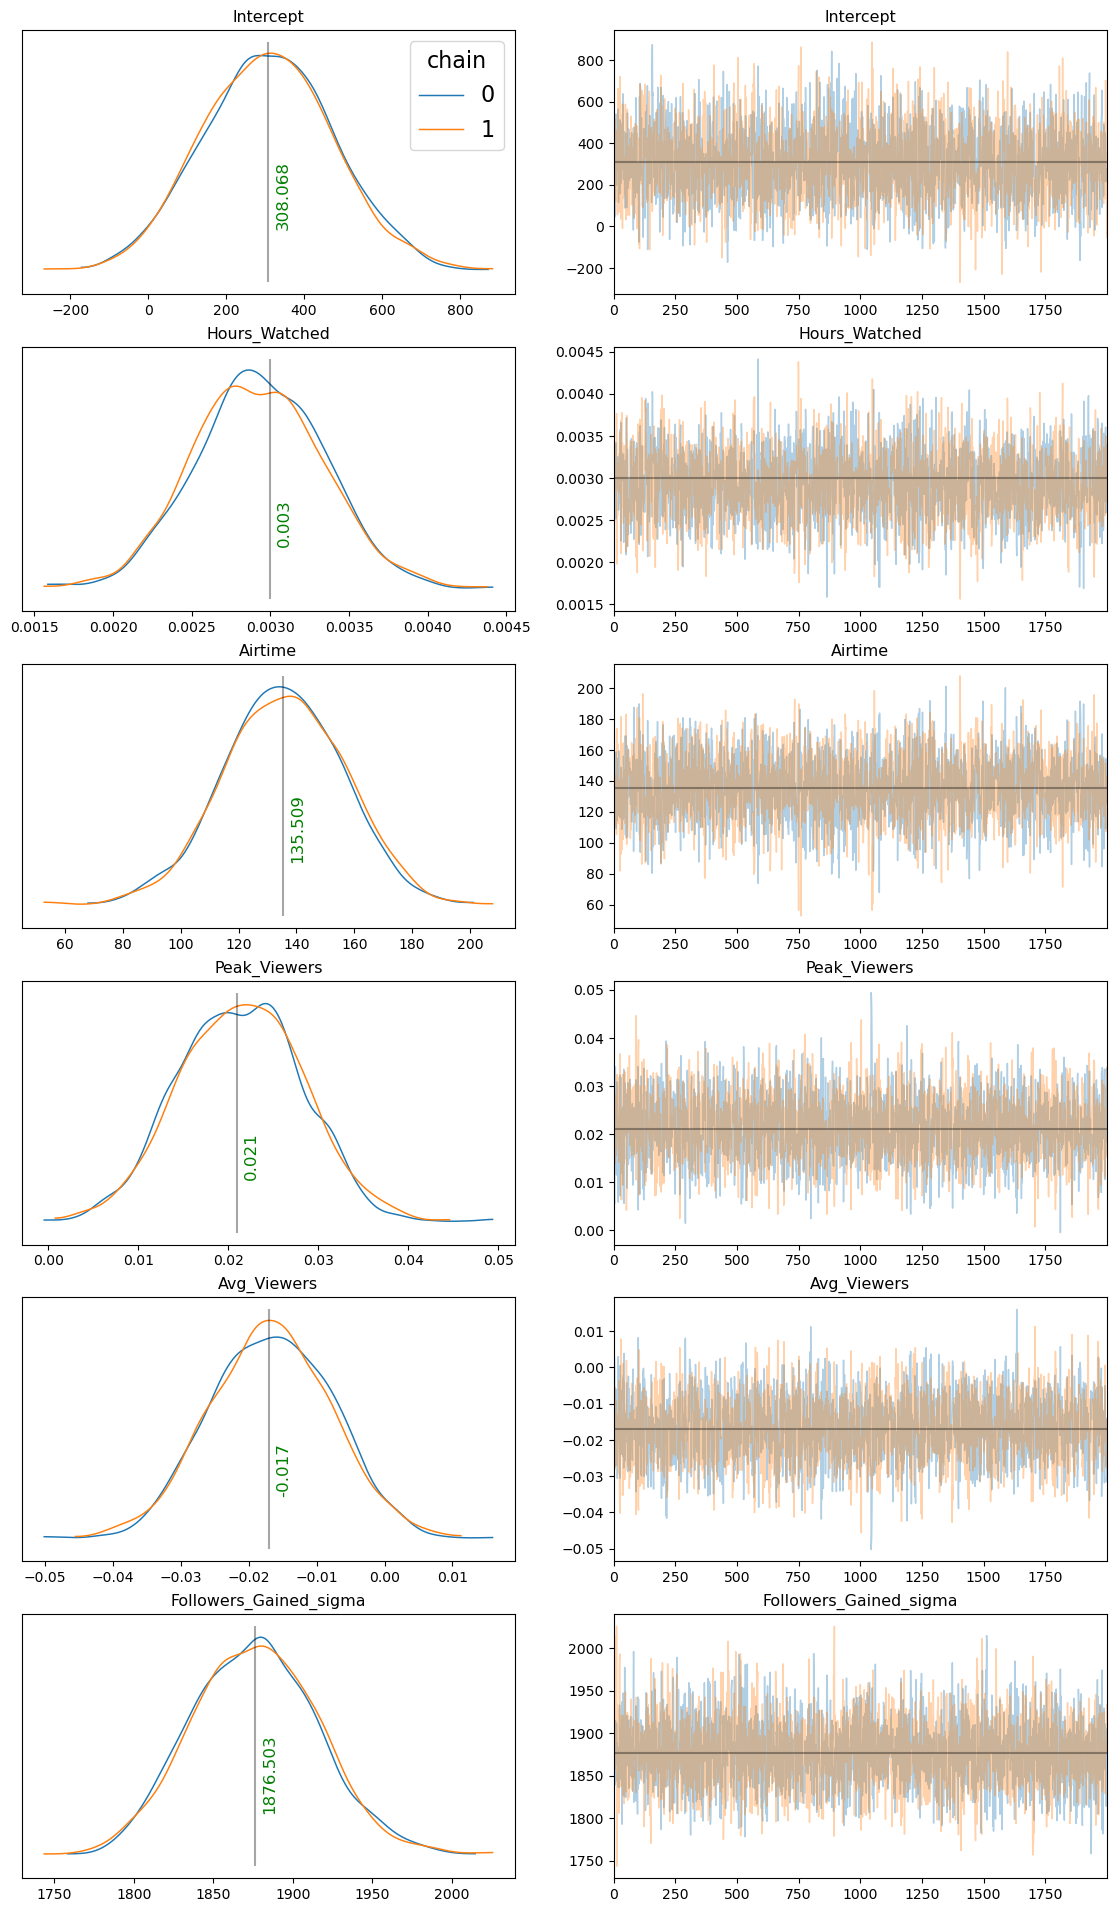

In [146]:
plot_traces(normal_trace)

In [147]:
# az.plot_trace(normal_trace, filter_vars="like")

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

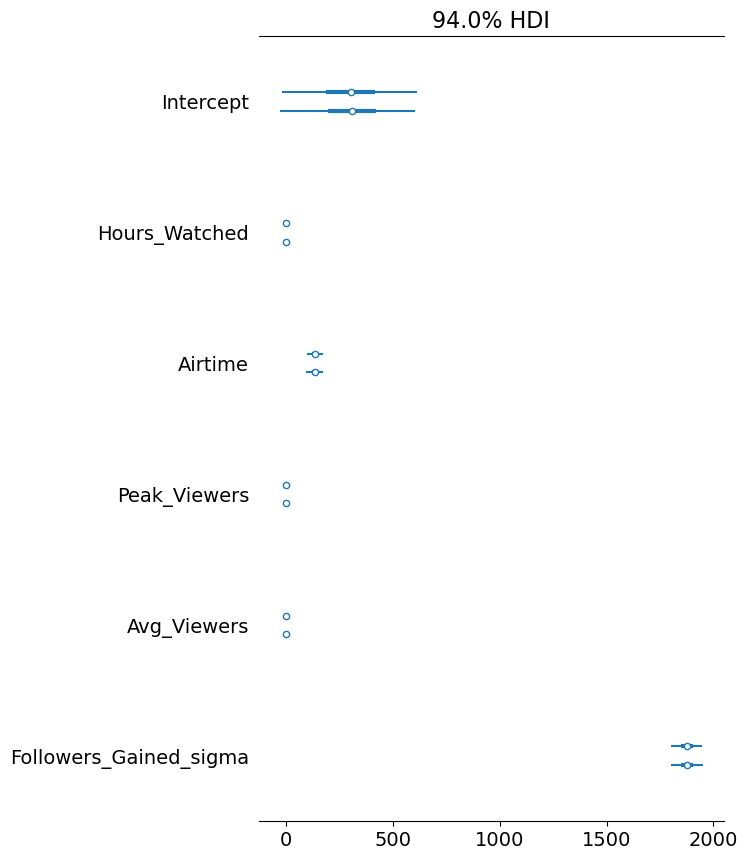

In [148]:
# Plot normal trace
az.plot_forest(normal_trace)

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Hours_Watched'}>,
        <Axes: title={'center': 'Airtime'}>],
       [<Axes: title={'center': 'Peak_Viewers'}>,
        <Axes: title={'center': 'Avg_Viewers'}>,
        <Axes: title={'center': 'Followers_Gained_sigma'}>]], dtype=object)

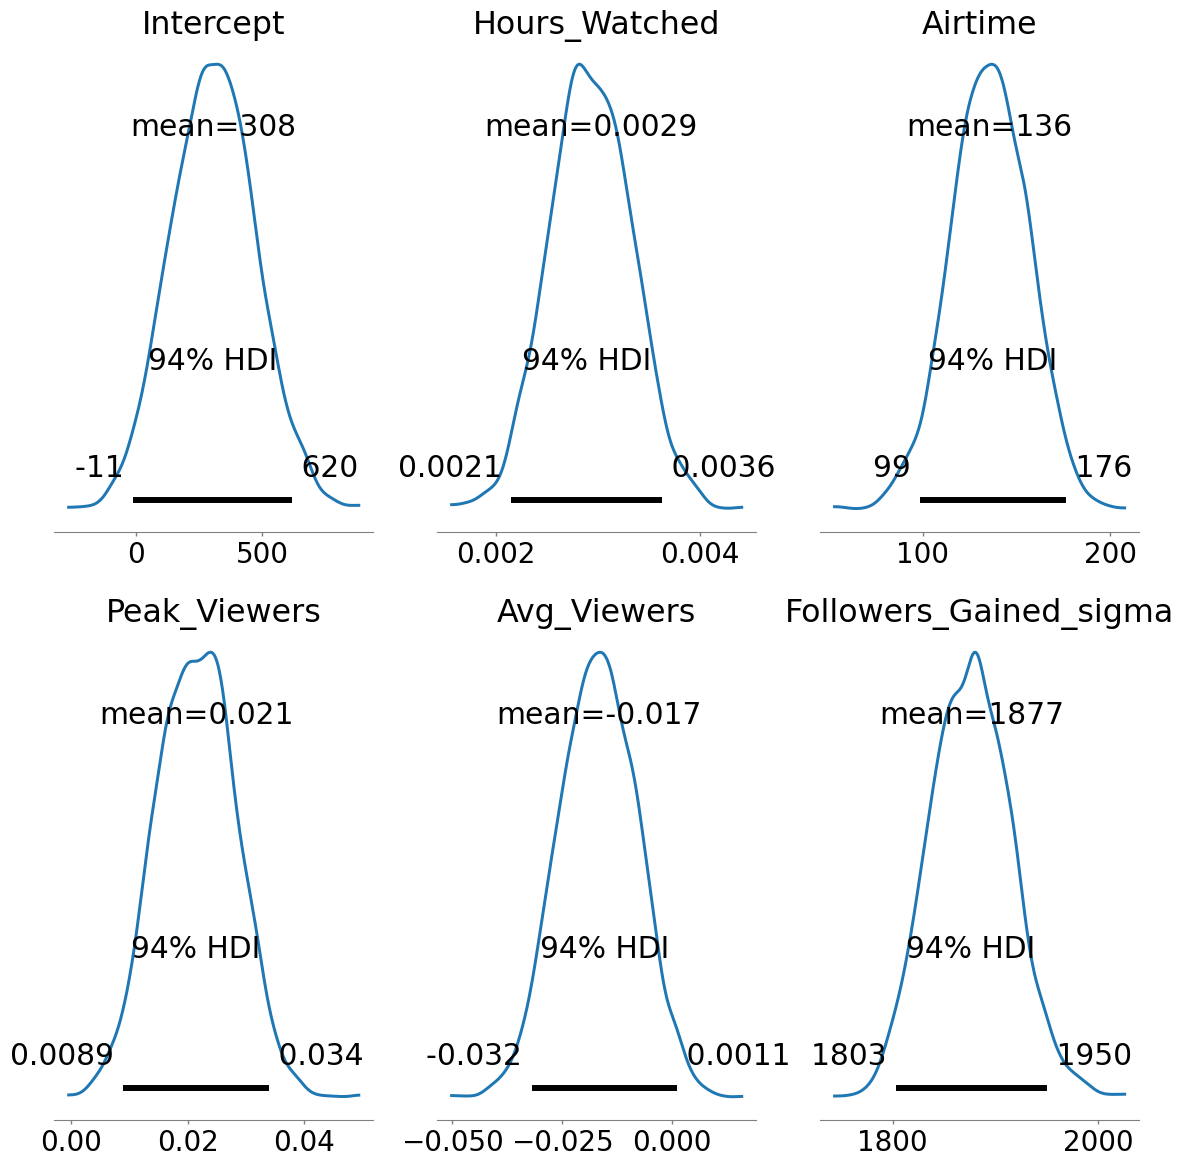

In [149]:
# Plot posterior
az.plot_posterior(normal_trace, figsize = (14, 14), textsize=20)

In [150]:
# list(normal_trace.posterior.keys())
# print(normal_trace.posterior["Hours_Watched"])

In [151]:
# Metrics for mean weight of each variables
for variable in list(normal_trace.posterior.keys()):
    print('Variable: {:15} Mean weight in model: {:.4f}'.format(variable, np.mean(normal_trace.posterior[variable])))

Variable: Intercept       Mean weight in model: 308.0678
Variable: Hours_Watched   Mean weight in model: 0.0029
Variable: Airtime         Mean weight in model: 135.5087
Variable: Peak_Viewers    Mean weight in model: 0.0214
Variable: Avg_Viewers     Mean weight in model: -0.0167
Variable: Followers_Gained_sigma Mean weight in model: 1876.5031


In [152]:
# Print a summary for normal trace of each variables
pm.summary(normal_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,308.068,167.712,-11.400,619.713,3.325,2.366,2542.0,2714.0,1.0
Hours_Watched,0.003,0.000,0.002,0.004,0.000,0.000,2372.0,2575.0,1.0
Airtime,135.509,20.747,98.530,176.223,0.419,0.296,2459.0,2682.0,1.0
Peak_Viewers,0.021,0.007,0.009,0.034,0.000,0.000,2508.0,2559.0,1.0
Avg_Viewers,-0.017,0.009,-0.032,0.001,0.000,0.000,2363.0,2399.0,1.0
Followers_Gained_sigma,1876.503,39.716,1802.844,1949.803,0.657,0.464,3653.0,2575.0,1.0


In [153]:
# Get an intercept and coefficient values for each variables
model_formula = 'Followers_Gained = '
for variable in normal_trace.posterior.keys():
    model_formula += ' %0.8f * %s +' % (np.mean(normal_trace.posterior[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'Followers_Gained =  308.06778372 * Intercept + 0.00292707 * Hours_Watched + 135.50867806 * Airtime + 0.02140650 * Peak_Viewers + -0.01672110 * Avg_Viewers + 1876.50307273 * Followers_Gained_sigma'

## Result

#### In order to address the problem of the prediction of big broadcasters’ followers gain based on their streaming metrics of airtime, peak viewers, average viewers, and hours watched, we applied our statistical model to the XQC broadcasting statistics dataset from 2019 to 2023.

#### We first filtered outliers using the interquartile range method. Then, we split the dataset, allocating 75\% for training and 25\% for testing. We employed Bayesian linear regression with the formula followers gained ~ hours watched + airtime + peak viewers + average viewers and processed the training set through the No-U-Turn Sampler algorithm, an enhanced Markov Chain Monte Carlo method. To predict new data points, we used the model's parameters to estimate a mean, incorporating the standard deviation from these parameters, and took the mean of each parameter from the trace as the optimal estimate.

In [154]:
# Evalute the MCMC trace and compare to ml models
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results):
    
    # Create a dictionary for each parameter and place posterior keys for all sampled value into it
    posterior_for_variables = {}
    for variable in list(normal_trace.posterior.keys()):
        posterior_for_variables[variable] = trace.posterior[variable]
    
    # print(type(var_dict["Hours_Watched"]))
    # print("end")
    flattened_posterior_for_variables = {k: v.values.flatten() for k, v in posterior_for_variables.items()}

    # Dataframe the results
    weights_for_variables = pd.DataFrame(flattened_posterior_for_variables)

    # Get means for all the weights
    means_for_variables = weights_for_variables.mean(axis=0)
    
    # Initiliza and create an intercept column for X_test
    X_test['Intercept'] = 1
    
    # Match names of the test observations and means
    variables_in_dataset = X_test.columns[1:]
    X_test = X_test.loc[:, variables_in_dataset]
    means_for_variables = means_for_variables[variables_in_dataset]
    
    # Use the average weights to compute estimate for each test observation 
    estimated_results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        estimated_results.loc[row[0], 'estimate'] = np.dot(np.array(means_for_variables), np.array(row[1]))
        
    # Compute necessary metrics for the comparison
    actual = np.array(y_test)
    errors = estimated_results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    
    # Add the results to the comparison dataframe
    model_results.loc['Bayesian LR', :] = [mae, rmse]
    
    plt.figure(figsize=(12, 8))
    
    # Plot MAE of all models
    ax = plt.subplot(1, 3, 2)
    model_results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'r', ax = ax)
    plt.title('Model MAE Comparison'); plt.ylabel('MAE'); 
    plt.tight_layout()
    
    # Plot RMSE of all models
    ax = plt.subplot(1, 3, 3)
    model_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b', ax = ax)
    plt.title('Model RMSE Comparison'); plt.ylabel('RMSE')
    
    return model_results

#### To evaluate our Bayesian Linear Regression model's performance further, we evaluated the accuracy of our Bayesian Linear Regression method against four alternatives (Random Forest, Linear Regression, Support Vector Machines, and Baseline) on a test set. Our method showed Bayesian Linear Regression’s comparable performance to standard models and significantly outperformed the baseline. The primary advantages of Bayesian Linear Regression lie in its interpretability and the ability to quantify uncertainty. This comparison highlights that Bayesian Linear Regression might struggle with complex, non-linear relationships without specific tailoring. 

In [155]:
normal_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [156]:
results

,mae,rmse
Linear Regression,1276.071265,1718.036577
Random Forest,1150.554074,1638.559502
SVM,2082.496099,2666.070514
Baseline,2089.569149,2672.055318


Model  MAE: 1276.2975
Model RMSE: 1717.9562


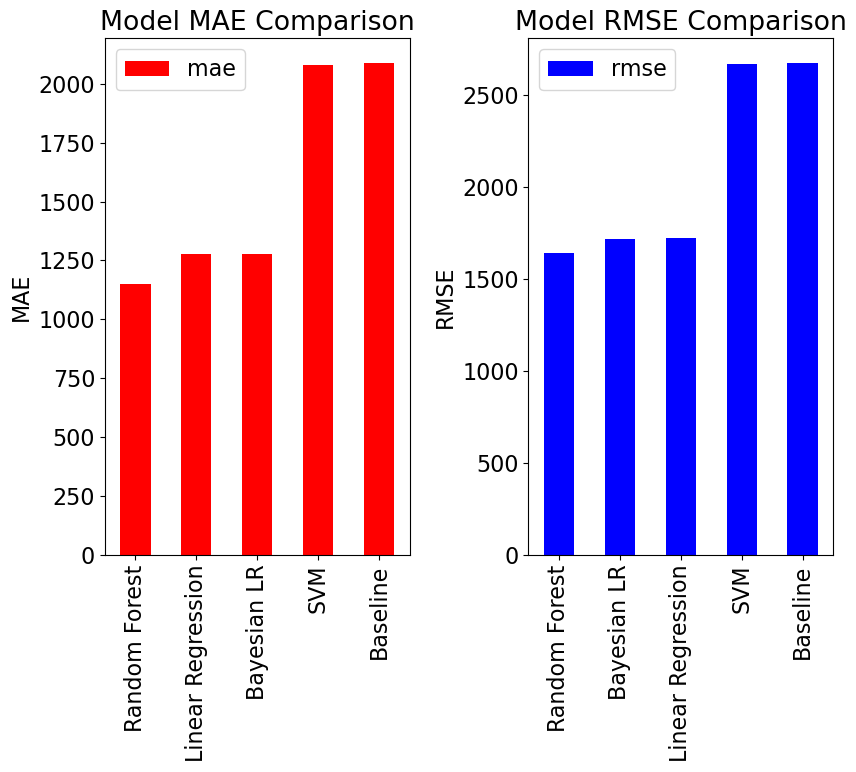

In [157]:
# Execution of model comparison
Comparison_with_BLR_results = evaluate_trace(normal_trace, X_train, X_test, y_train, y_test, results)

In [158]:
# Metrics for the model comparison
Comparison_with_BLR_results

,mae,rmse
Linear Regression,1276.071265,1718.036577
Random Forest,1150.554074,1638.559502
SVM,2082.496099,2666.070514
Baseline,2089.569149,2672.055318
Bayesian LR,1276.297465,1717.956182


# Model

#### We tested our model on a sample from the test set with the following metrics: followers gained (2067), hours watched (328,307 hours), airtime (7.42 hours), peak viewers (58,609), and average viewers (44,266), plus a pre-configured intercept of 1. We compared the model's estimated mean (optimal estimate) of followers gained against the actual figure. The closeness of the actual followers (2067) to the estimated mean (2788.2483) indicates good model accuracy.


In [159]:
# Make a new prediction from the test set and compare to actual value
def prediction_from_test_set(trace, test_observation):
    
    # Print the test observation data
    print('Test Observation:')
    print(test_observation)
    
    posterior_for_variables = {}
    for variable in list(normal_trace.posterior.keys()):
        posterior_for_variables[variable] = trace.posterior[variable]

    flattened_posterior_for_variables = {var_names: metrics_for_var.values.flatten() for var_names, metrics_for_var in posterior_for_variables.items()}

    # Dataframe the results
    weights_for_variables = pd.DataFrame(flattened_posterior_for_variables)
    
    # Compute the standard deviation of the likelihood
    standard_deviation = weights_for_variables['Followers_Gained_sigma'].mean()

    # Actual Values
    observed_values = test_observation['Followers_Gained']
    
    # Initilize the and create a intercept term for observarations
    test_observation['Intercept'] = 1
    test_observation = test_observation.drop('Followers_Gained')
    
    # Match weights and test observation
    weights_for_variables = weights_for_variables[test_observation.index]

    # Compute means for all the weights
    means_for_variables = weights_for_variables.mean(axis=0)

    # Get location of mean for observation
    location_of_mean = np.dot(means_for_variables, test_observation)
    
    # Compute the estimates of Followers_Gained
    estimates = np.random.normal(loc = location_of_mean, scale = standard_deviation, size = 1000)

    # Plot all the estimates
    plt.figure(figsize(8, 8))
    sns.displot(data = estimates, kind="kde",label = 'Estimated Dist.')

    # Plot the actual followers gained
    plt.vlines(x = observed_values, ymin = 0, ymax = 0.0003, 
               linestyles = '--', colors = 'red',
               label = 'True Followers_Gained',
              linewidth = 2.5)
    
    # Plot the mean estimate
    plt.vlines(x = location_of_mean, ymin = 0, ymax = 0.0003, 
               linestyles = '-', colors = 'orange',
               label = 'Mean Estimate',
              linewidth = 2.5)
    
    plt.legend(loc = 1)
    plt.title('Density Plot for Test Observation')
    plt.xlabel('Followers_Gained'); plt.ylabel('Density')
    
    # Prediction information
    print('True Followers_Gained = %d' % observed_values)
    print('Average Estimate = %0.4f' % location_of_mean)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

In [160]:
# Metrics visualization
X_test.iloc[41]

Followers_Gained      5605.000000
Hours_Watched       410799.000000
Airtime                  8.583333
Peak_Viewers         62459.000000
Avg_Viewers          47861.000000
Intercept                1.000000
Name: 467, dtype: float64

In [161]:
# Metrics visualization
X_test.iloc[30]

Followers_Gained      2067.000000
Hours_Watched       328307.000000
Airtime                  7.416667
Peak_Viewers         58609.000000
Avg_Viewers          44266.000000
Intercept                1.000000
Name: 1496, dtype: float64

Test Observation:
Followers_Gained      2067.000000
Hours_Watched       328307.000000
Airtime                  7.416667
Peak_Viewers         58609.000000
Avg_Viewers          44266.000000
Intercept                1.000000
Name: 1496, dtype: float64
True Followers_Gained = 2067
Average Estimate = 2788.5071
5% Estimate = -386.3309    95% Estimate = 6032.6235


C:\Users\thech\AppData\Local\Temp\ipykernel_19116\3507190940.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_observation['Intercept'] = 1
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x800 with 0 Axes>

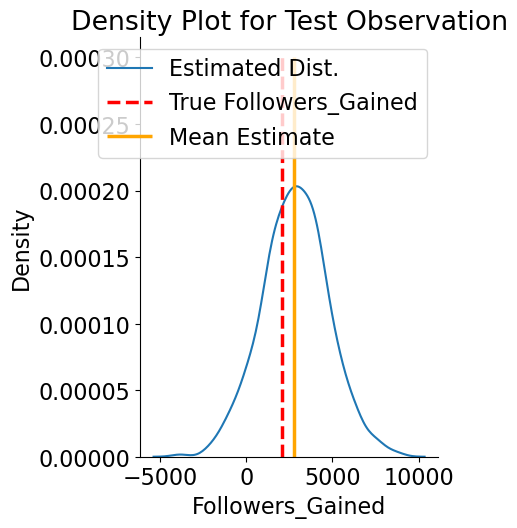

In [162]:
# Perform prediction 1
prediction_from_test_set(normal_trace, X_test.iloc[30])

Test Observation:
Followers_Gained        0.000000
Hours_Watched        3374.000000
Airtime                 0.083333
Peak_Viewers        43766.000000
Avg_Viewers         40483.000000
Intercept               1.000000
Name: 1595, dtype: float64


C:\Users\thech\AppData\Local\Temp\ipykernel_19116\3507190940.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_observation['Intercept'] = 1
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


True Followers_Gained = 0
Average Estimate = 589.1930
5% Estimate = -2470.8482    95% Estimate = 3811.5665


<Figure size 800x800 with 0 Axes>

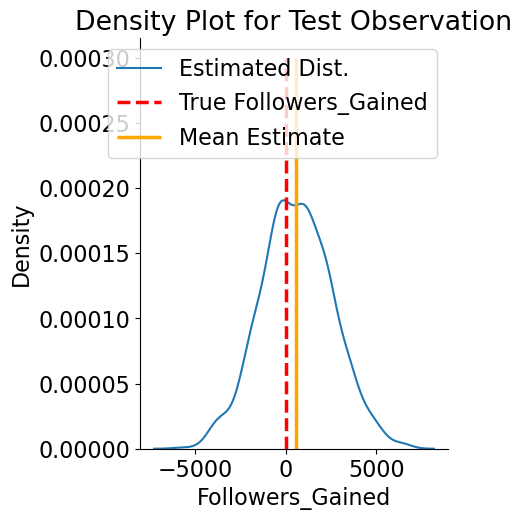

In [163]:
# Perform prediction 2
prediction_from_test_set(normal_trace, X_test.iloc[16])

In [164]:
# Make predictions for a new observation (datapoint) from the model trace
def prediction_from_a_new_observation(trace, new_observation):
    
    # Print information about the new observation
    print('New Observation')
    print(new_observation)
    # Dictionary of all sampled values for each parameter
    posterior_for_variables = {}
    for variable in list(normal_trace.posterior.keys()):
        posterior_for_variables[variable] = trace.posterior[variable]

    flattened_posterior_for_variables = {var_names: metrics_for_var.values.flatten() for var_names, metrics_for_var in posterior_for_variables.items()}

    # Compute the standard deviation of the likelihood
    standard_deviation = posterior_for_variables['Followers_Gained_sigma'].mean()
    
    # Dataframe the results
    weights_for_variables = pd.DataFrame(flattened_posterior_for_variables)
    
    # Match weights and new observation
    weights_for_variables = weights_for_variables[new_observation.index]
    
    # Compute means for each variable
    means_for_variables = weights_for_variables.mean(axis=0)
    
    # Compute mean for observation for each variable
    location_of_mean = np.dot(means_for_variables, new_observation)
    
    # Compute distribution of estimates
    estimates = np.random.normal(loc = location_of_mean, scale = standard_deviation,
                                 size = 1000)
    
    # Plot the estimate distribution
    plt.figure(figsize(8, 8))
    sns.displot(data = estimates, kind="kde",label = 'Estimated Dist.')
    # Plot the mean estimate
    plt.vlines(x = location_of_mean, ymin = 0, ymax = 0.0003, 
               linestyles = '-', colors = 'orange', linewidth = 2.5)
    plt.title('Density Plot for New Observation')
    plt.xlabel('Followers_Gained'); plt.ylabel('Density')
    
    # Estimate information
    print('Average Estimate = %0.4f' % location_of_mean)
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))

New Observation
Intercept             1.0
Hours_Watched    240000.0
Airtime              11.0
Peak_Viewers      32054.0
Avg_Viewers       25083.0
dtype: float64


c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Average Estimate = 2767.9098
5% Estimate = -363.3940    95% Estimate = 5977.4291


<Figure size 800x800 with 0 Axes>

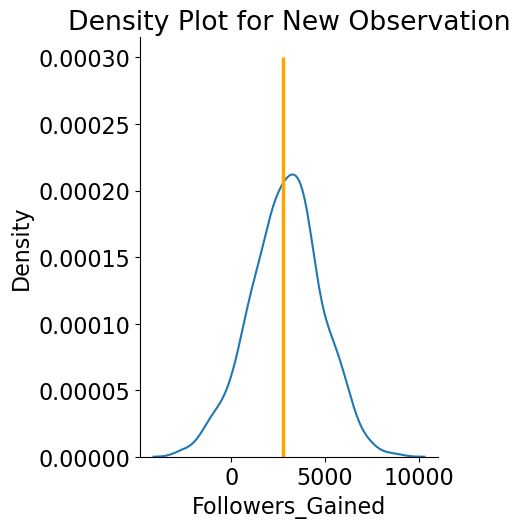

In [165]:
# Create an observation by assigning an actual value to each parameter and intercept term
observation = pd.Series({'Intercept': 1, 'Hours_Watched': 240000.0, 'Airtime': 11.0, 
                            'Peak_Viewers': 32054, 'Avg_Viewers': 25083})

# Perform a prediction by our model
prediction_from_a_new_observation(normal_trace, observation)

New Observation
Intercept             1.0
Hours_Watched    353133.0
Airtime              15.6
Peak_Viewers      49412.0
Avg_Viewers       32331.0
dtype: float64


c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\thech\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Average Estimate = 3972.7780
5% Estimate = 984.3408    95% Estimate = 7033.6437


<Figure size 800x800 with 0 Axes>

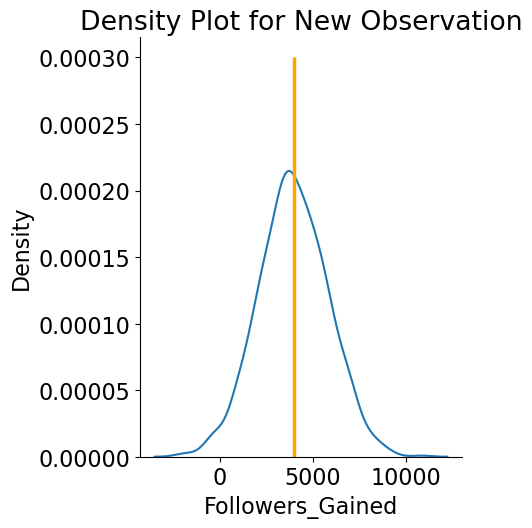

In [166]:
# Observation creation for each features and a intercept
observation = pd.Series({'Intercept': 1, 'Hours_Watched': 353133.0, 'Airtime': 15.6, 
                            'Peak_Viewers': 49412, 'Avg_Viewers': 32331})

# Perform a prediction by our model
prediction_from_a_new_observation(normal_trace, observation)

## Discussion

#### Bayesian Linear Regression is not the best prediction model. The main benefits of Linear Modeling are not in the accuracy, but in the interpretability and the quantification of our uncertainty. It shows good distributions of our predictions by using Bayesian linear regression with the NUTS for the posteriors. By using the model, those big Live broadcasters can predict the possibility of follower growth through daily streaming data, and then plan live broadcast goals.

#### As for more flaws of our model for this problem, we did not take date into account in our model. Our model could be improved by applying ARIMAX, leveraging each variable indexed by time t and then the predictive distribution is based on the previous objective variable indexed by time t-1 with feature variables. Also, we did not take Festival and game trends those hidden variable into account. Future work can apply the autoregressive model with lagged variables to reproduce the same experiment and compare the results. 